# Import Library

In [203]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import random
import matplotlib.pyplot as plt
from math import floor
import warnings
import tensorflow as tf
from scipy.optimize import minimize, rosen, rosen_der
from bayes_opt import BayesianOptimization
from itertools import cycle
from scipy import interp
import itertools

from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_regression
from sklearn import svm, datasets
from sklearn.multiclass import OneVsRestClassifier

import keras
from keras.layers import LeakyReLU
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical 
from keras import layers
from keras import models
from keras import utils as np_utils
from keras.layers import Flatten
from keras.layers import Dropout, Activation, BatchNormalization 
from keras.regularizers import l2
from keras import datasets
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl,RMSprop

# Prepare Data

In [3]:
df=pd.read_csv("data.csv")
df.head()

In [5]:
df_train_valid, df_test = \
    train_test_split(df, test_size=0.2, random_state=25)

In [6]:
dum_df = pd.get_dummies(df_train_valid, columns=["OSclassification"], prefix=["Class"] )
# merge with main df bridge_df on key values
dum_df.head()

,Sex,Age,Edmondson.stage,TumorNumber,MicrovasuLarInvasion,Capsule,AFP,HBsAg,HBeAg,TBIL,...,Diameter,LocalResection,Segmentectomy,Bisegmentectomy,Semi.hepatectomy,Trisegmentectomy,Recurrence,Class_1,Class_2,Class_3
175,1,47,3,1,1,0,48.9,1,0,9.2,...,4.3,1,0,0,0,0,1,0,1,0
149,1,46,3,2,1,0,1210.0,1,0,12.2,...,4.3,1,0,0,0,0,1,1,0,0
126,1,52,2,1,0,0,23.7,1,0,17.8,...,8.0,1,0,0,0,0,1,1,0,0
357,1,44,2,1,1,0,1210.0,1,0,22.5,...,10.0,0,0,1,0,0,1,0,1,0
332,1,52,3,1,0,0,79.7,1,1,16.2,...,5.0,0,0,1,0,0,0,0,0,1


In [179]:
print(dum_df.shape,df_test.shape)

(299, 24) (75, 22)


In [8]:
X = dum_df.iloc[:, 0:21].values
y = dum_df.iloc[:, 21:25].values
X_test = df_test.iloc[:, 0:21].values
y_test = df_test.iloc[:, 21:23].values
print(X.shape, y.shape, X_test.shape, y_test.shape)

(299, 21) (299, 3) (75, 21) (75, 1)


In [9]:
# Normolize X
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

# Build Neural Network Model

In [335]:
epochs=30
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [349]:
# build the model
model = Sequential()
model.add(Dense(21, activation='relu', input_shape=(X.shape[1],), kernel_initializer='uniform'))
model.add(Dense(48, kernel_initializer='uniform', activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(3, kernel_initializer='uniform', activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
                                
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)

In [350]:
batch_size = int(X.shape[0]/100)
# you invoke the LearningRateScheduler during the .fit() phase
model_history = model.fit(X, y,epochs=epochs,callbacks=[save_best], batch_size=batch_size, 
                          verbose=2,validation_split=0.25,shuffle = True)

Epoch 1/30
112/112 - 0s - loss: 1.0943 - accuracy: 0.3839 - val_loss: 1.0792 - val_accuracy: 0.4667 - 449ms/epoch - 4ms/step
Epoch 2/30
112/112 - 0s - loss: 1.0886 - accuracy: 0.4107 - val_loss: 1.0715 - val_accuracy: 0.4667 - 129ms/epoch - 1ms/step
Epoch 3/30
112/112 - 0s - loss: 1.0874 - accuracy: 0.4107 - val_loss: 1.0701 - val_accuracy: 0.4667 - 135ms/epoch - 1ms/step
Epoch 4/30
112/112 - 0s - loss: 1.0869 - accuracy: 0.4107 - val_loss: 1.0678 - val_accuracy: 0.4667 - 135ms/epoch - 1ms/step
Epoch 5/30
112/112 - 0s - loss: 1.0875 - accuracy: 0.4107 - val_loss: 1.0662 - val_accuracy: 0.4667 - 132ms/epoch - 1ms/step
Epoch 6/30
112/112 - 0s - loss: 1.0871 - accuracy: 0.4107 - val_loss: 1.0665 - val_accuracy: 0.4667 - 128ms/epoch - 1ms/step
Epoch 7/30
112/112 - 0s - loss: 1.0864 - accuracy: 0.4107 - val_loss: 1.0676 - val_accuracy: 0.4667 - 136ms/epoch - 1ms/step
Epoch 8/30
112/112 - 0s - loss: 1.0868 - accuracy: 0.4107 - val_loss: 1.0661 - val_accuracy: 0.4667 - 128ms/epoch - 1ms/step


# Learning Curve

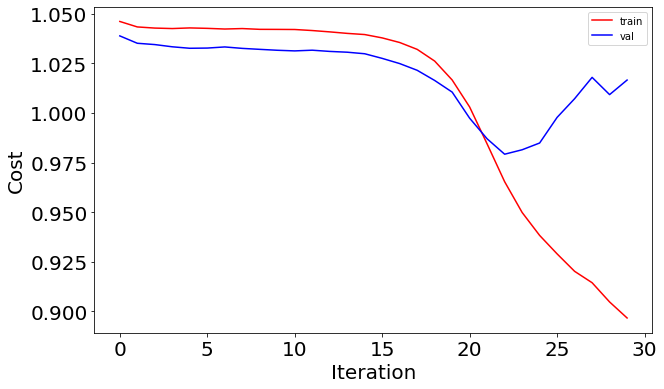

In [351]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Iteration', fontsize=20)
ax.set_ylabel(r'Cost', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

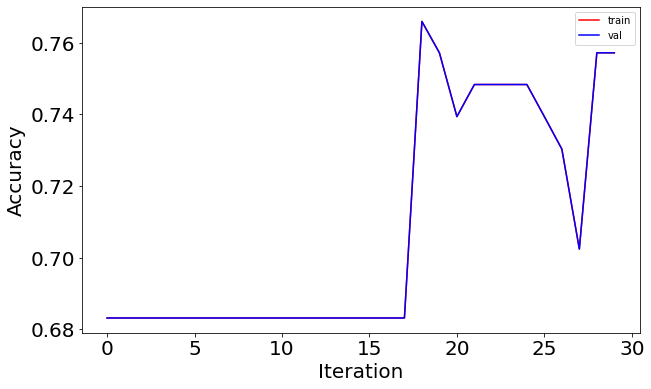

In [352]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['val_accuracy']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Iteration', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Truning Parameters

In [295]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(
                        X, y, test_size=0.2, random_state=11)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize=(10,6))
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("m", fontsize=14) 
    plt.ylabel("Cost", fontsize=14)        

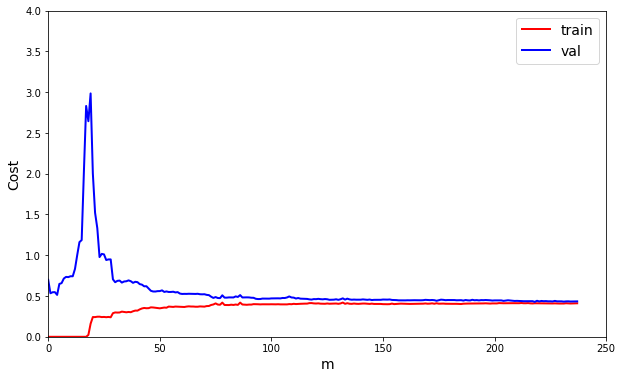

In [296]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 250, 0, 4])                         
plt.show()

In [288]:
y_test_onehot = to_categorical(y_test-1, num_classes=0)

In [353]:
score = model.evaluate(X_test, y_test_onehot, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  56.0 %


# ROC Curve

In [354]:
predictions=model.predict(x=X_test, batch_size=10, verbose=2)
predictions

8/8 - 0s - 45ms/epoch - 6ms/step


array([[0.02575913, 0.24131969, 0.7329211 ],
       [0.13682213, 0.35844272, 0.5047351 ],
       [0.84179544, 0.12342288, 0.03478166],
       [0.8305172 , 0.13104641, 0.03843636],
       [0.8787946 , 0.09766191, 0.02354341],
       [0.7898683 , 0.15759207, 0.05253968],
       [0.08373905, 0.32683632, 0.58942455],
       [0.13535205, 0.36273575, 0.50191224],
       [0.836793  , 0.12701413, 0.03619285],
       [0.21826275, 0.3722738 , 0.40946344],
       [0.7649119 , 0.17332256, 0.06176551],
       [0.17649385, 0.36654755, 0.4569586 ],
       [0.12705581, 0.35324076, 0.5197034 ],
       [0.7710354 , 0.16948216, 0.05948255],
       [0.34204963, 0.36312345, 0.29482692],
       [0.09232657, 0.333241  , 0.5744325 ],
       [0.5578645 , 0.28546098, 0.1566746 ],
       [0.1364104 , 0.36028403, 0.5033056 ],
       [0.02472457, 0.23909523, 0.73618025],
       [0.8363632 , 0.12716159, 0.03647532],
       [0.8139891 , 0.14197241, 0.04403849],
       [0.81545323, 0.14114384, 0.04340293],
       [0.

In [246]:
dum_df_test = pd.get_dummies(df_test, columns=["OSclassification"], prefix=["Class"] )
y_test_score=dum_df_test.iloc[:, 21:25].values
y_test_score

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0,

In [355]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],_ = roc_curve(y_test_score[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_score.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

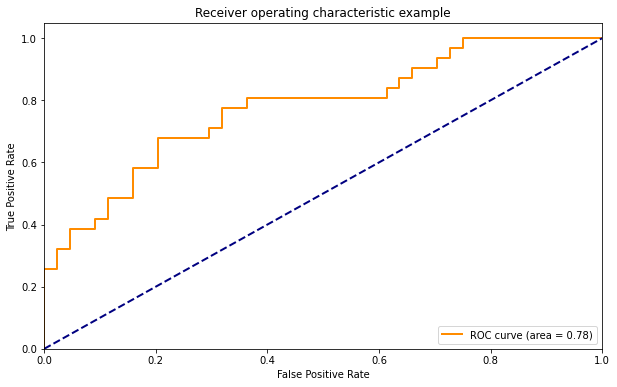

In [366]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

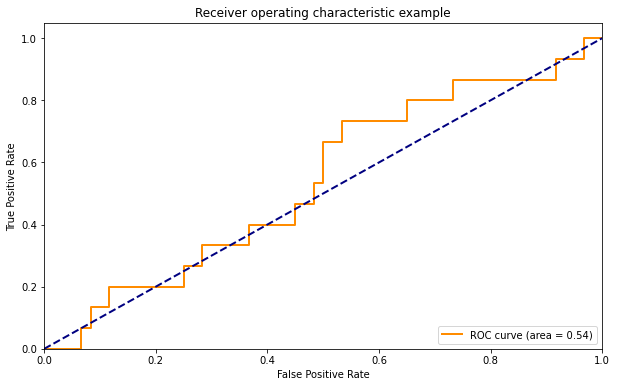

In [365]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

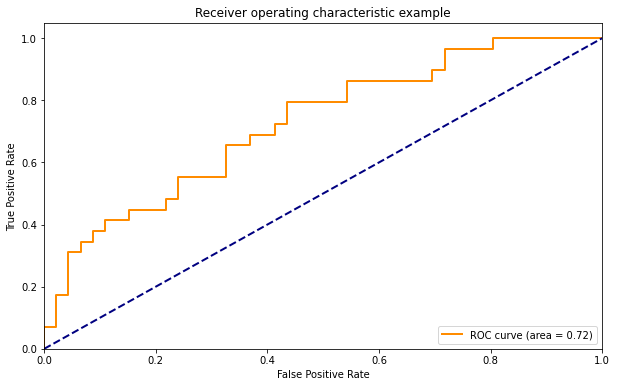

In [363]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

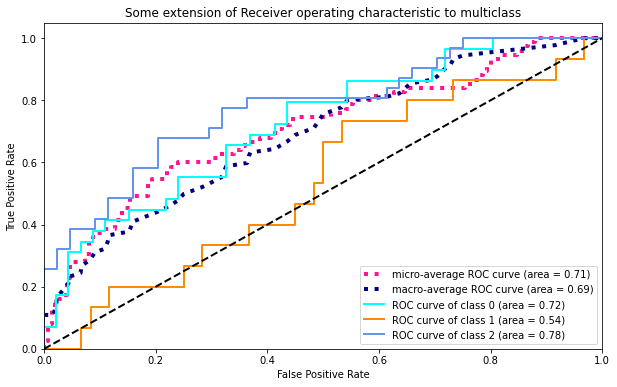

In [364]:

lw = 2

# First aggregate all false positive rates

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [360]:
rounded_predictions=np.argmax(predictions, axis=-1)
rounded_predictions+=1
rounded_predictions

array([3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 2, 3, 1, 3, 3, 1, 1, 1,
       3, 3, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 2, 1, 3,
       1, 1, 3, 3, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3,
       1, 1, 3, 3, 1, 3, 1, 3, 2], dtype=int64)

# Visualize The Prediction Results on The Test Data

In [361]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without Normalization")

    print(cm)

    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

Confusion Matrix without Normalization
[[18  2  9]
 [ 9  1  5]
 [ 6  2 23]]


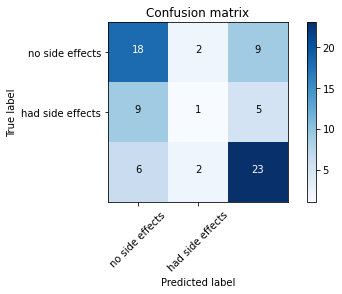

In [362]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)

cm_plot_labels = ['no side effects', 'had side effects']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)